In [1]:
# Purpose: Preparing the pre-industrial spin-up forcing datasets. Only the 
#          SAT, RLDS and HUSS files change by -0.133°C, -0.7 W m**-2 and
#          relative humidity staying constant
#          -> the remaining variables are from the RDF (repeat decade forcing)
#             over 1962-01-01 to 1971-31-12
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 22. 04. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps                                                                   
import os.path # to check if file exists
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.mpl.ticker as cticker
from matplotlib import ticker
from netCDF4 import Dataset    # Note: python is case-sensitive!

import cartopy.feature as cfeature

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "
myblue = [.19, .21, .58]

from dask.distributed import Client
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36151 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43335' processes=4 threads=16, memory=68.72 GB>

### Here the HEAVY-LIFTING: Preparation of forcing fields for the pre-industrial run

#### Achtung, zuerst den leeren Ordner mit Unterordern für alle Variablen erstellen bevor ich das Skript laufen lasse
> mkdir EXP_Southern_JRA55-do-1-3 \
> cd EXP_Southern_JRA55-do-1-3 \
> mkdir friver huss prra prsn psl rlds rsds tas uas vas

$$e = \frac{qp}{0.622+0.378q}$$
$$e_s(T)=e_s(T_0) \times \exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) } $$

$$q_{new} = \frac{e \times (0.622)}{\left( p\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }- 0.378e \right) } $$  

So what I need are the following files: q_1962, p_1962, temp_1962, temp_1859

In [2]:
# forcing = '1-3'
#              #   SAT (°C), RSWD (W m**-1)
# pi_offsets = [     -0.133,          -0.7]



# experiment = 'EXP_PI_Offset_JRA55-do-1-3/'
# # to accommodate the different forcing which has different naming conventions
# if forcing == '1-3':
#     base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
#     fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
#     version = 'gn/v20180412/'
#     hrPt_timestep = ['01010000','12312230']
#     hr_timestep = ['01010130','01010000']
#     day_timestep = ['0101','0101']
    
#     print('#########################################')    
#     print('        '+experiment+'        ')
#     print('#########################################')
#     var = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn'] # only eight of the variables I used in my Msc

#     a = np.linspace(1962,1972,11)

#     startTime = datetime.now() # start clock     

#     for i in [2,3,4]:                    # loop over the JRA55 variables that I need to change: tas, huss and rsds,          range(0,9):
#         for year in range(0,10):         # loop over the first ten years, i.e., the RDF period  range(0,46):
#             year_a = str(int(a[year]))
#             year_aa = str(int(a[year+1]))
#             startTime = datetime.now()   # start clock     
            
#             print('Year ' + year_a + ' & ' + var[i])   # print year 

              

#             # get correct subfolder, either 'atmos', 'land' or 'landIce'
#             if var[i] == 'friver' and forcing == '1-3':
#                 domain = 'ocean/'
#             elif var[i] == 'friver' and forcing == '1-4-0':
#                 domain = 'land/'
#             elif var[i] == 'licalvf':
#                 domain = 'landIce/'
#             else:
#                 domain = 'atmos/'

#             # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
#             if var[i] in ['rsds','rlds','prra','prsn']:
#                 res = '3hr/'
#             elif var[i] in ['psl','tas','huss','uas','vas']:
#                 res = '3hrPt/'
#             else:
#                 res = 'day/'
             
#             # load in data for climatological RDF forcing 
#             ds1 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_a + '*',combine = 'by_coords', 
#                                     chunks = {'time': 1},decode_times = True) # open dataset
            
            
#             # -------------------------------------------- #
#             # pre-industrial offset adjustment here        #
#             # -------------------------------------------- #
#             if var[i] == 'tas':
#                 ds1['tas'] = ds1.tas + pi_offsets[0] # adjust with pre-industrial offset: substract 0.133 °C
                     
#             if var[i] == 'rlds':
#                 ds1['rlds'] = ds1.rlds + pi_offsets[1] # adjust with pre-industrial offset: subtract 0.7 W m**-2
                
#             if var[i] in ['huss']:
#                 # for the constant relative humidity calculation, I need RDF specific humidity, RDF sea level pressure as well as RDF and PI surface air temperature 
#                 huss_rdf = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
#                 psl_rdf = xr.open_mfdataset(base + domain + res + var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset
                
#                 tas_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
#                                            combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
#                 tas_rdf = xr.open_mfdataset(base + domain + res + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

#                 # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
#                 e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf)
#                 e_s_0 = 6.11*100 #Pa
#                 T_0 = 273.15 #K

#                 L = 2.5*10**6 #J/kg
#                 R_w = 462.52#J/kgK
                
     
#                 ds2 = e_rdf*0.622/(psl_rdf*np.exp(L/R_w *(1/tas_pi - 1/tas_rdf))-0.378*e_rdf)
#                 # load in initial file to have the correct data structure
#                 ds1 = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True) # open dataset
#                 ds1['huss'] = ds2

#         # from here on save the files
#         # different file names depending on the variables
#             if var[i] in ['uas','vas','tas','psl','huss']:
#                 # construct filename for output file, e.g.
#                 # filename = '/g/data/e14/mv7494/HeatDist_input/EXP_tropics_JRA55-do-1-3//uas/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_197201010000-12312230.nc'
#                 filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
#                 if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
#                     continue                
#                 else: 
#                     ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file
#             elif var[i] in ['prra','prsn','rlds','rsds']:
#                 filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hr_timestep[0] + '-' + year_aa + hr_timestep[1] + '.nc'
#                 if os.path.isfile(filename) == True:
#                     continue
#                 else: 
#                     ds1.to_netcdf(filename)
#             elif var[i] == 'friver':
#                 if forcing == '1-3':
#                     filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_aa + day_timestep[1] + '.nc'
#                 else:
#                     filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

#                 if os.path.isfile(filename) == True:
#                     continue
#                 else: 
#                     ds1.to_netcdf(filename)

#             # ok this works, but is missing the lat/lon/bnds fields

#             print(datetime.now() - startTime) # end time of script
#             print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
#             print('') 
#         # Note: Saving one month of data takes 18 seconds
#         # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#         print('#########################################')    
#         print('#           Variable finished           #')
#         print('#########################################')

# ### Checking the TAS, RSDS and HUSS files if all calculations correct

### Checking if offset in TAS is correct

In [3]:
input = '/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-3/'
tas_rdf = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hrPt/tas/gn/v20180412/'+
                            'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010000-196212312230.nc').tas[0,:,:].load() # open dataset
tas_pi = xr.open_dataset(input + 'tas/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010000-196212312230.nc').tas[0,:,:].load()


(tas_rdf-tas_pi).mean(['lat','lon']).values # ok, all correct. The pre-industrial offset is 0.1329956 °C

array(0.1329956, dtype=float32)

### Checking if offset in RLDS is correct

In [4]:
rlds_rdf = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hr/rlds/gn/v20180412/'+
                            'rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010130-196301010000.nc').rlds[0,:,:].load() # open dataset
rlds_pi = xr.open_dataset(input + 'rlds/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010130-196301010000.nc').rlds[0,:,:].load()


(rlds_rdf-rlds_pi).mean(['lat','lon']).values # ok, all correct. The pre-industrial offset is 0.7 W m**-2

array(0.7000067, dtype=float32)

### Checking if relative humidity is constant

In [5]:
year_a ='1962'; res = '3hrPt/'; experiment = 'EXP_PI_Offset_JRA55-do-1-3/'
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
version = 'gn/v20180412/'
hrPt_timestep = ['01010000','12312230']; hr_timestep = ['01010130','01010000']; day_timestep = ['0101','0101']
var = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn'] # only eight of the variables I used in my Msc

# load in all files required
huss_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
huss_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[3] + '/' + var[3] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
psl_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset

tas_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
tas_rdf = xr.open_mfdataset(base + 'atmos/' + res + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset


In [6]:
# copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf) # water vapour pressure in RDF period
e_pi = huss_pi*psl_rdf/(0.622+0.378*huss_pi)      # water vapour pressure in PI (pre-industrial) period

e_s_0 = 6.11*100 #Pa
T_0 = 273.15 #K

L = 2.5*10**6 #J/kg
R_w = 462.52#J/kgK


e_s_rdf = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_rdf)) # saturation water vapour pressure in RDF period
e_s_pi = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_pi))   # saturation water vapour pressure in PI period

rel_humid_rdf = e_rdf/e_s_rdf # relative humidity in RDF period
rel_humid_pi = e_pi/e_s_pi    # relative humidity in PI period

Text(0.5, 1.0, 'Change in RH')

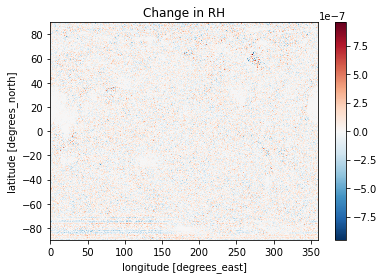

In [7]:
(rel_humid_rdf-rel_humid_pi).isel(time = 0).plot()
plt.title('Change in RH')

Note that the change in relative humidity is not exactly equal to zero because I have only used constants to 3 significant figures.

Text(0.5, 1.0, 'Relative error of change in RH')

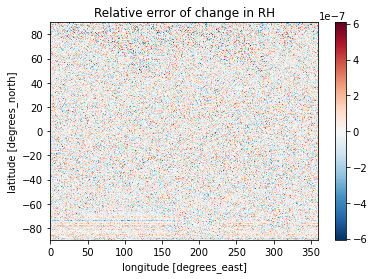

In [8]:
# relative error
((rel_humid_rdf-rel_humid_pi)/rel_humid_rdf).isel(time=2919).plot(); plt.title('Relative error of change in RH')

### Linear increase of the forcing again to get out of the PI-Offset back up to the 1962 forcing
- I need to linearly increase the forcing files once again over nine decades with the last decade being the 1962-71 forcing with no changes
- from output192 (1882-91) to output200 (1962-71)

In [9]:
%%time
forcing = '1-3'
             #   SAT (°C), RSWD (W m**-1)
pi_offsets = [     -0.133,          -0.7]
slope =      np.abs([     -0.133/81,          -0.7/80])

lauf_variablen = [81,71,61,51,41,31,21,11] # this number goes from 80 during the first iteration (lauf_variable-1) down to 1
# and each time it gets multiplied with the -slope so it basically adds a positive increment to -0.133 all the way to 0.0 after 80 years


for i in range(191,199,1):

    experiment = 'EXP_PI_Offset_JRA55-do-1-3/forcing_output' + str(i) + '/'

#    print('scale = ' + str(scaling_factor)) # scaling linearly each iteration/output from 0.8 down to 0.1
    
    # output191 = RDF - PI-Offset
    # output192 = RDF - PI-Offset * 0.88
    # output193 = RDF - PI-Offset * 0.77
    # ...         ...               ...
    # output200 = RDF - PI-Offset * 0.00
    
    # to accommodate the different forcing which has different naming conventions
    if forcing == '1-3':
        base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
        fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
        version = 'gn/v20180412/'
        hrPt_timestep = ['01010000','12312230']
        hr_timestep = ['01010130','01010000']
        day_timestep = ['0101','0101']
        print('#########################################################')    
        print('---   '+experiment+'   ---')
        print('#########################################################')    
        var = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn'] # only eight of the variables I used in my Msc

        a = np.linspace(1962,1972,11)
     
  


        for v in [2,3,4]:                    # loop over the JRA55 variables that I need to change: tas, huss and rsds,          range(0,9):
            lauf_variable = lauf_variablen[i-191]  
            for year in range(0,10):         # loop over the first ten years, i.e., the RDF period  range(0,46):
                lauf_variable = lauf_variable - 1
                print(lauf_variable)
                startTime = datetime.now()   # start clock
                # for tas:   -0.133°C * 0.88        + the difference between two ten year blocks multiplied by a 1/10th scaling factor
                # so  that the scaling goes over ten years from -0.133°C*0.88 up to -0.133°C*0.77
                if var[v] == 'tas':
                    z = -slope[0]*lauf_variable # ich addiere jede iteration der Schlaufe 1/80stel des scaling factors hinzu bis dass ich nach 80 Jahren wieder bei 0.0 bin
                                                # output191 has scaling 1.0, ...then scaling back to 1962 levels and output200 has scaling 0.0
                                                # -> minus sign here because I need to positively add the slope so that the scaling decreases from -0.133 back to 0.0 
                elif var[v] == 'huss':
                    z = 0
                elif var[v] == 'rlds':
                    z = -slope[1]*lauf_variable
                   
                year_a = str(int(a[year]))
                year_aa = str(int(a[year+1]))
                startTime = datetime.now()   # start clock                     
                
                print('Year ' + year_a + ' & ' + var[v]+': '+str(z))   # print year, variable and offset


                # get correct subfolder, either 'atmos', 'land' or 'landIce'
                if var[v] == 'friver' and forcing == '1-3':
                    domain = 'ocean/'
                elif var[v] == 'friver' and forcing == '1-4-0':
                    domain = 'land/'
                elif var[v] == 'licalvf':
                    domain = 'landIce/'
                else:
                    domain = 'atmos/'

                # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
                if var[v] in ['rsds','rlds','prra','prsn']:
                    res = '3hr/'
                elif var[v] in ['psl','tas','huss','uas','vas']:
                    res = '3hrPt/'
                else:
                    res = 'day/'

                # load in data for climatological RDF forcing 
                ds1 = xr.open_mfdataset(base + domain + res + var[v] + '/' + version + var[v] + fname + year_a + '*',combine = 'by_coords', 
                                        chunks = {'time': 1},decode_times = True) # open dataset


                # -------------------------------------------- #
                # pre-industrial offset adjustment here        #
                # -------------------------------------------- #
                if var[v] == 'tas':
                    ds1['tas'] = ds1.tas + z
                    # adjust with pre-industrial offset: substract 0.133 °C but now add a scaling factor to linearly go back to 1962-71 levels

                if var[v] == 'rlds':
                    ds1['rlds'] = ds1.rlds + z
                    # adjust with pre-industrial offset: subtract 0.7 W m**-2 but now add a scaling factor to linearly go back to 1962-71 levels

                if var[v] in ['huss']:
                    # for the constant relative humidity calculation, I need RDF specific humidity, RDF sea level pressure as well as RDF and PI surface air temperature 
                    huss_rdf = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
                    psl_rdf = xr.open_mfdataset(base + domain + res + var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset

                    tas_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                                               combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
                    tas_rdf = xr.open_mfdataset(base + domain + res + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

                    # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
                    e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf)
                    e_s_0 = 6.11*100 #Pa
                    T_0 = 273.15 #K

                    L = 2.5*10**6 #J/kg
                    R_w = 462.52#J/kgK


                    ds2 = e_rdf*0.622/(psl_rdf*np.exp(L/R_w *(1/tas_pi - 1/tas_rdf))-0.378*e_rdf)
                    # load in initial file to have the correct data structure
                    ds1 = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True) # open dataset
                    ds1['huss'] = ds2

            # from here on save the files
            # different file names depending on the variables
                if var[v] in ['uas','vas','tas','psl','huss']:
                    # construct filename for output file, e.g.
                    # filename = '/g/data/e14/mv7494/HeatDist_input/EXP_tropics_JRA55-do-1-3//uas/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_197201010000-12312230.nc'
                    filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[v] + '/' + var[v] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
                    if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
                        continue                
                    else: 
                        ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file
                elif var[v] in ['prra','prsn','rlds','rsds']:
                    filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[v] + '/' + var[v] + fname + year_a + hr_timestep[0] + '-' + year_aa + hr_timestep[1] + '.nc'
                    if os.path.isfile(filename) == True:
                        continue
                    else: 
                        ds1.to_netcdf(filename)
                elif var[v] == 'friver':
                    if forcing == '1-3':
                        filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[v]+ '/' + var[v] + fname + year_a + day_timestep[0] + '-' + year_aa + day_timestep[1] + '.nc'
                    else:
                        filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[v]+ '/' + var[v] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

                    if os.path.isfile(filename) == True: # skip if file already exists
                        continue
                    else: 
                        ds1.to_netcdf(filename)

                # ok this works, but is missing the lat/lon/bnds fields

                print(datetime.now() - startTime) # end time of script
                print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
            # Note: Saving one month of data takes 18 seconds
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            print('#########################################################')    
            print('---                 Variable finished                 ---')
            print('#########################################################')

    ### Wall time: 22 min 19s for a ten year block
#CPU times: user 58min 59s, sys: 4min 53s, total: 1h 3min 52s
# Wall time: 2h 40min 12s          for the full eight decades

#########################################################
---   EXP_PI_Offset_JRA55-do-1-3/forcing_output191/   ---
#########################################################
80
Year 1962 & tas: -0.13135802469135804
79
Year 1963 & tas: -0.12971604938271605
78
Year 1964 & tas: -0.1280740740740741
77
Year 1965 & tas: -0.1264320987654321
76
Year 1966 & tas: -0.12479012345679014
75
Year 1967 & tas: -0.12314814814814816
74
Year 1968 & tas: -0.12150617283950618
73
Year 1969 & tas: -0.1198641975308642
72
Year 1970 & tas: -0.11822222222222223
71
Year 1971 & tas: -0.11658024691358025
#########################################################
---                 Variable finished                 ---
#########################################################
80
Year 1962 & huss: 0
79
Year 1963 & huss: 0
78
Year 1964 & huss: 0
77
Year 1965 & huss: 0
76
Year 1966 & huss: 0
75
Year 1967 & huss: 0
74
Year 1968 & huss: 0
73
Year 1969 & huss: 0
72
Year 1970 & huss: 0
71
Year 1971 & huss: 0
###############

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


32
Year 1970 & rlds: -0.27999999999999997
31
Year 1971 & rlds: -0.27125
#########################################################
---                 Variable finished                 ---
#########################################################
#########################################################
---   EXP_PI_Offset_JRA55-do-1-3/forcing_output196/   ---
#########################################################
30
Year 1962 & tas: -0.04925925925925926
29
Year 1963 & tas: -0.04761728395061729
28
Year 1964 & tas: -0.04597530864197531


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


27
Year 1965 & tas: -0.044333333333333336
26
Year 1966 & tas: -0.04269135802469136
25
Year 1967 & tas: -0.04104938271604939
24
Year 1968 & tas: -0.03940740740740741
23
Year 1969 & tas: -0.037765432098765435


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


22
Year 1970 & tas: -0.03612345679012346
21
Year 1971 & tas: -0.03448148148148148
#########################################################
---                 Variable finished                 ---
#########################################################
30
Year 1962 & huss: 0
29
Year 1963 & huss: 0
28
Year 1964 & huss: 0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


27
Year 1965 & huss: 0
26
Year 1966 & huss: 0
25
Year 1967 & huss: 0
24
Year 1968 & huss: 0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


23
Year 1969 & huss: 0
22
Year 1970 & huss: 0
21
Year 1971 & huss: 0
#########################################################
---                 Variable finished                 ---
#########################################################
30
Year 1962 & rlds: -0.26249999999999996
29
Year 1963 & rlds: -0.25375
28
Year 1964 & rlds: -0.24499999999999997


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


27
Year 1965 & rlds: -0.23625
26
Year 1966 & rlds: -0.22749999999999998
25
Year 1967 & rlds: -0.21874999999999997
24
Year 1968 & rlds: -0.20999999999999996
23
Year 1969 & rlds: -0.20124999999999998


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


22
Year 1970 & rlds: -0.19249999999999998
21
Year 1971 & rlds: -0.18374999999999997
#########################################################
---                 Variable finished                 ---
#########################################################
#########################################################
---   EXP_PI_Offset_JRA55-do-1-3/forcing_output197/   ---
#########################################################
20
Year 1962 & tas: -0.03283950617283951
19
Year 1963 & tas: -0.031197530864197534
18
Year 1964 & tas: -0.029555555555555557


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17
Year 1965 & tas: -0.027913580246913584
16
Year 1966 & tas: -0.026271604938271607
15
Year 1967 & tas: -0.02462962962962963
14
Year 1968 & tas: -0.022987654320987656
13
Year 1969 & tas: -0.02134567901234568


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12
Year 1970 & tas: -0.019703703703703706
11
Year 1971 & tas: -0.01806172839506173
#########################################################
---                 Variable finished                 ---
#########################################################
20
Year 1962 & huss: 0
19
Year 1963 & huss: 0
18
Year 1964 & huss: 0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17
Year 1965 & huss: 0
16
Year 1966 & huss: 0
15
Year 1967 & huss: 0
14
Year 1968 & huss: 0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


13
Year 1969 & huss: 0
12
Year 1970 & huss: 0
11
Year 1971 & huss: 0
#########################################################
---                 Variable finished                 ---
#########################################################
20
Year 1962 & rlds: -0.175
19
Year 1963 & rlds: -0.16624999999999998
18
Year 1964 & rlds: -0.15749999999999997


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


17
Year 1965 & rlds: -0.14875
16
Year 1966 & rlds: -0.13999999999999999
15
Year 1967 & rlds: -0.13124999999999998
14
Year 1968 & rlds: -0.12249999999999998
13
Year 1969 & rlds: -0.11374999999999999


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


12
Year 1970 & rlds: -0.10499999999999998
11
Year 1971 & rlds: -0.09624999999999999
#########################################################
---                 Variable finished                 ---
#########################################################
#########################################################
---   EXP_PI_Offset_JRA55-do-1-3/forcing_output198/   ---
#########################################################
10
Year 1962 & tas: -0.016419753086419756
9
Year 1963 & tas: -0.014777777777777779
8
Year 1964 & tas: -0.013135802469135803


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7
Year 1965 & tas: -0.011493827160493828
6
Year 1966 & tas: -0.009851851851851853
5
Year 1967 & tas: -0.008209876543209878
4
Year 1968 & tas: -0.006567901234567902
3
Year 1969 & tas: -0.0049259259259259265


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2
Year 1970 & tas: -0.003283950617283951
1
Year 1971 & tas: -0.0016419753086419754
#########################################################
---                 Variable finished                 ---
#########################################################
10
Year 1962 & huss: 0
9
Year 1963 & huss: 0
8
Year 1964 & huss: 0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7
Year 1965 & huss: 0
6
Year 1966 & huss: 0
5
Year 1967 & huss: 0
4
Year 1968 & huss: 0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3
Year 1969 & huss: 0
2
Year 1970 & huss: 0
1
Year 1971 & huss: 0
#########################################################
---                 Variable finished                 ---
#########################################################
10
Year 1962 & rlds: -0.0875
9
Year 1963 & rlds: -0.07874999999999999
8
Year 1964 & rlds: -0.06999999999999999


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7
Year 1965 & rlds: -0.06124999999999999
6
Year 1966 & rlds: -0.05249999999999999
5
Year 1967 & rlds: -0.04375
4
Year 1968 & rlds: -0.034999999999999996
3
Year 1969 & rlds: -0.026249999999999996


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2
Year 1970 & rlds: -0.017499999999999998
1
Year 1971 & rlds: -0.008749999999999999
#########################################################
---                 Variable finished                 ---
#########################################################
CPU times: user 31.6 s, sys: 5.95 s, total: 37.5 s
Wall time: 1min 6s


### Checking if the linear scaling of the offset is done correctly, here for surface air temperature & longwave downward radiation

In [10]:
%%time

scale = np.linspace(1,0,10)

for i in range(191,199):

    period = 'output' + str(i)
    print(period)
    print('--- --- --- --- ---')

    lauf_variable = lauf_variablen[i-191]  
    lauf_variable = lauf_variable - 1
    print(lauf_variable)
   
    z1 = -slope[0]*lauf_variable; z2 = -slope[1]*lauf_variable 
    
    input = '/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-3/forcing_'+period+'/'
    tas_rdf = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hrPt/tas/gn/v20180412/'+
                                'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010000-196212312230.nc').tas[0,:,:].load() # open dataset
    tas_pi_scale = xr.open_dataset(input + 'tas/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010000-196212312230.nc').tas[0,:,:].load()

    print('[value from .nc file, manually calculated value, difference]')

    rlds_rdf = xr.open_mfdataset('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hr/rlds/gn/v20180412/'+
                                'rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010130-196301010000.nc').rlds[0,:,:].load() # open dataset
    rlds_pi_scale = xr.open_dataset(input + 'rlds/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010130-196301010000.nc').rlds[0,:,:].load()

    a = (tas_rdf-tas_pi_scale).mean(['lat','lon']).values      # the pi-offset value from the SAT .nc file
    b = abs(z1)                                                # the calculated pi-offset value
    c = (rlds_rdf-rlds_pi_scale).mean(['lat','lon']).values    # the pi-offset value from the RLDS .nc file
    d = abs(z2)                                                # the calculated pi-offset value
    print([a, b, a-b]) # ok, all correct. 
    print([c, d, c-d]) # ok, all correct. The pre-industrial offset is 0.7 W m**-2 * 0.88 = 0.622 for the output192 (the first scaling)

# NOICE!

output191
--- --- --- --- ---
80
[value from .nc file, manually calculated value, difference]
[array(0.13135043, dtype=float32), 0.13135802469135804, -7.596825375988381e-06]
[array(0.7000067, dtype=float32), 0.7, 6.723403930708471e-06]
output192
--- --- --- --- ---
70
[value from .nc file, manually calculated value, difference]
[array(0.11493196, dtype=float32), 0.11493827160493827, -6.308220786815921e-06]
[array(0.6124933, dtype=float32), 0.6124999999999999, -6.723403930597449e-06]
output193
--- --- --- --- ---
60
[value from .nc file, manually calculated value, difference]
[array(0.0985135, dtype=float32), 0.09851851851851852, -5.0196161976573395e-06]
[array(0.52499413, dtype=float32), 0.5249999999999999, -5.86509704580962e-06]
output194
--- --- --- --- ---
50
[value from .nc file, manually calculated value, difference]
[array(0.08209229, dtype=float32), 0.08209876543209878, -6.480275848777528e-06]
[array(0.4375, dtype=float32), 0.43749999999999994, 5.551115123125783e-17]
output195
-

### Checking if relative humidity is constant

EXP_PI_Offset_JRA55-do-1-3/forcing_output192/


<timed exec>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


EXP_PI_Offset_JRA55-do-1-3/forcing_output193/


<timed exec>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


EXP_PI_Offset_JRA55-do-1-3/forcing_output194/


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
<timed exec>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


EXP_PI_Offset_JRA55-do-1-3/forcing_output195/


<timed exec>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


EXP_PI_Offset_JRA55-do-1-3/forcing_output196/


<timed exec>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


EXP_PI_Offset_JRA55-do-1-3/forcing_output197/


<timed exec>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


EXP_PI_Offset_JRA55-do-1-3/forcing_output198/


<timed exec>:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


EXP_PI_Offset_JRA55-do-1-3/forcing_output199/


OSError: no files to open

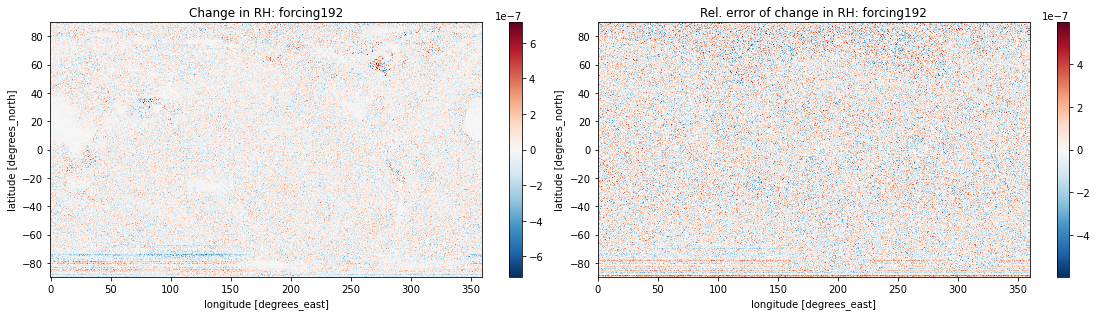

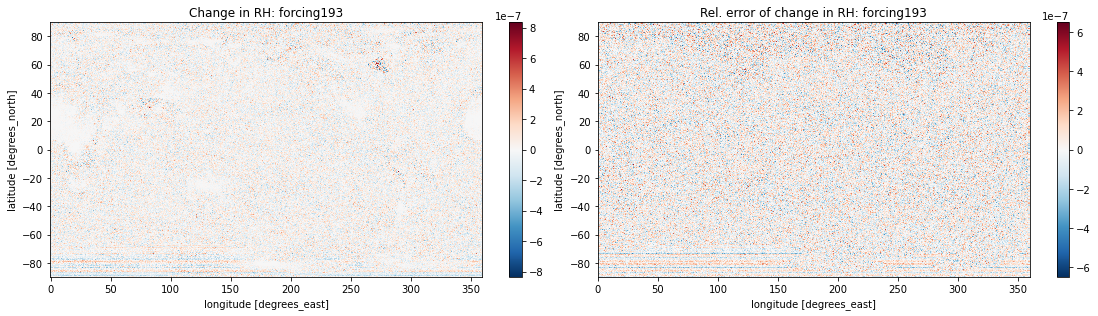

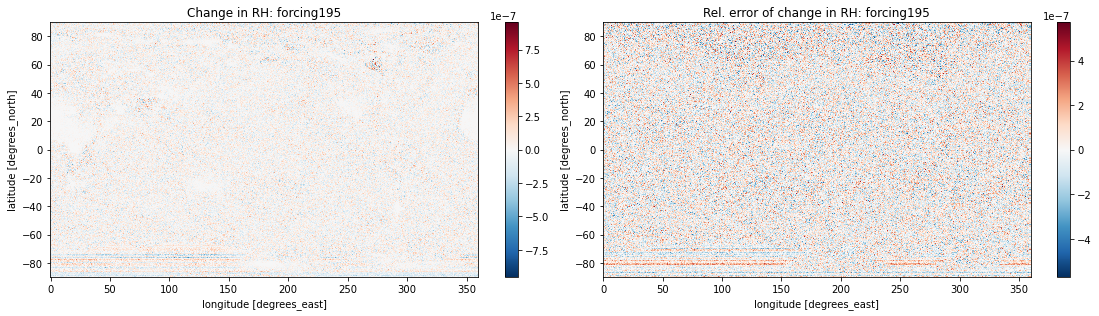

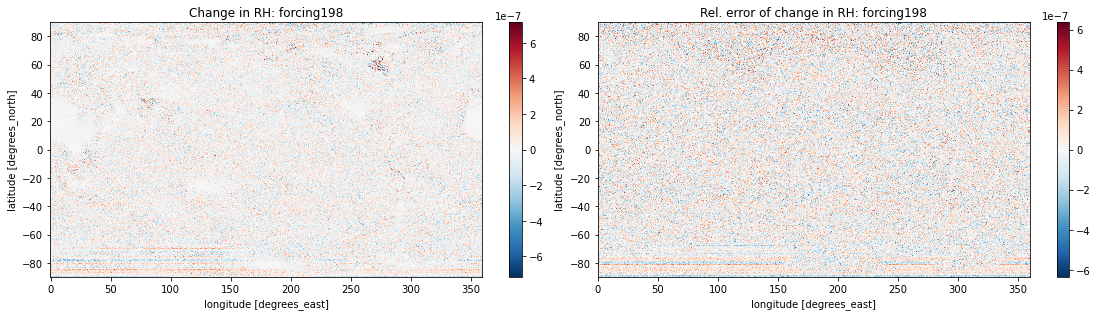

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [11]:
%%time

for i in range(192,201,1):

    experiment = 'EXP_PI_Offset_JRA55-do-1-3/forcing_output' + str(i) + '/'
    print(experiment)
    
    year_a ='1962'; res = '3hrPt/'
    # load in all files required
    huss_rdf = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
    huss_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[3] + '/' + var[3] + fname + year_a + hrPt_timestep[0] + '-' + year_a + 
                                hrPt_timestep[1] + '.nc',
                               combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
    psl_rdf = xr.open_mfdataset(base + domain + res + var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset

    tas_pi = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/' + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                               combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
    tas_rdf = xr.open_mfdataset(base + domain + res + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

    # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
    e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf) # water vapour pressure in RDF period
    e_pi = huss_pi*psl_rdf/(0.622+0.378*huss_pi)      # water vapour pressure in PI (pre-industrial) period

    e_s_0 = 6.11*100 #Pa
    T_0 = 273.15 #K

    L = 2.5*10**6 #J/kg
    R_w = 462.52#J/kgK


    e_s_rdf = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_rdf)) # saturation water vapour pressure in RDF period
    e_s_pi = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_pi))   # saturation water vapour pressure in PI period

    rel_humid_rdf = e_rdf/e_s_rdf # relative humidity in RDF period
    rel_humid_pi = e_pi/e_s_pi    # relative humidity in PI period


    fig = plt.figure(figsize=(16,4.5),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(1,2) 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1 = plt.subplot(gs[0,0])
    (rel_humid_rdf-rel_humid_pi).isel(time = 0).plot(); plt.title('Change in RH: forcing'+str(i))

    ax1 = plt.subplot(gs[0,1]) # relative error
    ((rel_humid_rdf-rel_humid_pi)/rel_humid_rdf).isel(time=2919).plot(); plt.title('Rel. error of change in RH: forcing'+str(i))

    # --- saving as 300 dpi .PNG image in specified folder ------------------------
    plt.savefig(save + 'checking_RH_forcing_constant_scaling_period_for_output'+str(i), dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
    # %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Wall time: 1min 57s
# All good, all figures show negligibly small changes in relative humidity (i.e., 1e6 magnitude smaller) and the relative error is also very, very small
# -> i.e., relative humidity is constant in all the scaling files

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #

In [12]:
'/g/data/e14/mv7494/HeatDist_input/' + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'

'/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-3/forcing_output199/tas/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_196201010000-196212312230.nc'

### Check if scaling is really what I intend to do

In [24]:
%%time
a = np.zeros(shape=(90,2)) # empty array which I then fill up
a[:,0] = np.linspace(1882,1971,90) # first column = year data

for i in [192]:#range(192,201):
    startTime = datetime.now()   # start clock 
    b = xr.open_mfdataset('/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-3/forcing_output'+str(i)+'/tas/tas*.nc').tas.mean(['lon','lat']).groupby('time.year').mean('time').values
    # Wall time: 5min 54s for one iteration
    for year in range(10):
        a[(i-192)*10+year,1] = b[year]
    print(datetime.now() - startTime) # end time of script

plt.plot(a)

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [14]:
a[0:10,1]

array([279.27642822, 279.1817627 , 278.98599243, 279.15753174,
       279.10003662, 279.25262451, 279.1550293 , 279.27276611,
       279.2684021 , 279.20568848])

In [15]:
i = 194
a = np.zeros(shape=(90,2)) # empty array which I then fill up
a[:,0] = np.linspace(1882,1971,90) # first column = year data

a

array([[1882.,    0.],
       [1883.,    0.],
       [1884.,    0.],
       [1885.,    0.],
       [1886.,    0.],
       [1887.,    0.],
       [1888.,    0.],
       [1889.,    0.],
       [1890.,    0.],
       [1891.,    0.],
       [1892.,    0.],
       [1893.,    0.],
       [1894.,    0.],
       [1895.,    0.],
       [1896.,    0.],
       [1897.,    0.],
       [1898.,    0.],
       [1899.,    0.],
       [1900.,    0.],
       [1901.,    0.],
       [1902.,    0.],
       [1903.,    0.],
       [1904.,    0.],
       [1905.,    0.],
       [1906.,    0.],
       [1907.,    0.],
       [1908.,    0.],
       [1909.,    0.],
       [1910.,    0.],
       [1911.,    0.],
       [1912.,    0.],
       [1913.,    0.],
       [1914.,    0.],
       [1915.,    0.],
       [1916.,    0.],
       [1917.,    0.],
       [1918.,    0.],
       [1919.,    0.],
       [1920.,    0.],
       [1921.,    0.],
       [1922.,    0.],
       [1923.,    0.],
       [1924.,    0.],
       [192